<a href="https://colab.research.google.com/github/Sonali-Shruthi/Cite_and_forget/blob/main/SNAMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CLASSIFYING PAPERS ENDURING VS FORGOTTEN:
Citation Metrics:
Early Citations: Sum of citations in years 1–5 after publication.
Late Citations: Sum of citations in years 6–10 after publication.
Classification Thresholds:
Early Threshold: 90th percentile of early citations (top 10%, high initial impact).
Late Threshold: 25th percentile of late citations (bottom 25%, low sustained impact).
Classification Criteria:
Forgotten: High early citations (≥ early threshold) and low late citations (≤ late threshold).
Enduring: High early citations (≥ early threshold) and high late citations (> late threshold).
Other: Papers not meeting Forgotten or Enduring criteria.




Columns in loaded_df:
['Article Id', 'Title', 'Author', 'Cited By ', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


<ipython-input-6-5c0852046c97>:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_published = df_long.groupby('Article Id').apply(get_year_published).reset_index(name='Year Published')



First 5 rows of long-format dataframe:
      Article Id                                         Title       Author  \
1384     9201001  On String Field Theory and Effective Actions  Amit Giveon   
2768     9201001  On String Field Theory and Effective Actions  Amit Giveon   
4152     9201001  On String Field Theory and Effective Actions  Amit Giveon   
5536     9201001  On String Field Theory and Effective Actions  Amit Giveon   
6920     9201001  On String Field Theory and Effective Actions  Amit Giveon   

      Cited By   Year  Citation Count  Year Published  
1384          3  1993               1          1993.0  
2768          3  1994               2          1993.0  
4152          3  1995               0          1993.0  
5536          3  1996               0          1993.0  
6920          3  1997               0          1993.0  

Long-format Info:
<class 'pandas.core.frame.DataFrame'>
Index: 38633 entries, 1384 to 44287
Data columns (total 7 columns):
 #   Column          Non

<ipython-input-6-5c0852046c97>:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paper_metrics = df.groupby('Article Id').apply(lambda g: pd.Series({



Classification Counts:
Status
Other       1129
Enduring     130
Name: count, dtype: int64

Sample Forgotten Papers:
Empty DataFrame
Columns: [Article Id, Title, Early Citations, Late Citations]
Index: []

Sample Enduring Papers:
    Article Id                                              Title  \
4      9201005       Infinite Symmetry in the Quantum Hall Effect   
6      9201007     Differential Geometry on Linear Quantum Groups   
12     9201013    Renormalization Group Approach to Matrix Models   
21     9201022  Conservation Laws and 2D Black Holes in Dilato...   
23     9201024  Integrable Systems for Particles with Internal...   

    Early Citations  Late Citations  
4                99              39  
6                71              26  
12               43              30  
21               63              49  
23               54              24  


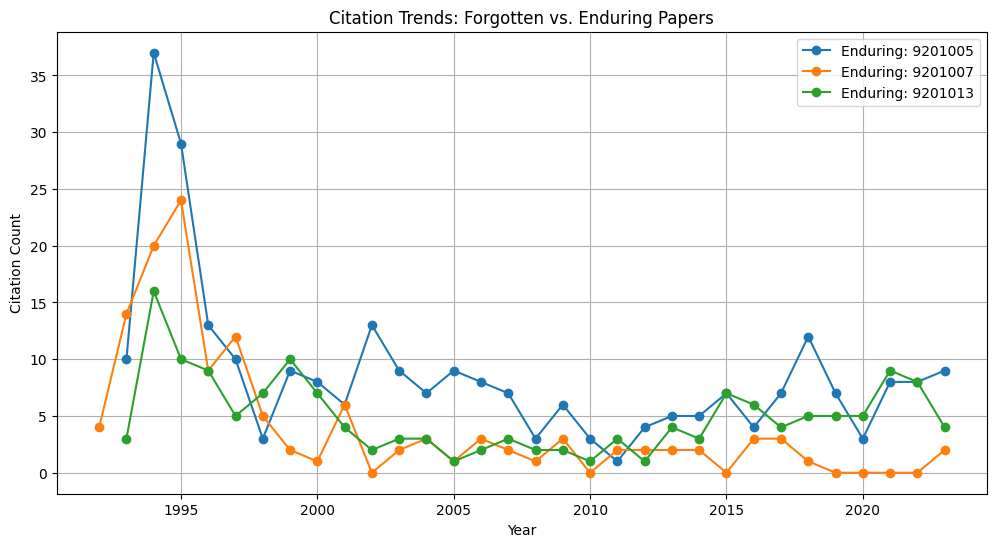

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure matplotlib/seaborn are installed
!pip install matplotlib seaborn

# Step 1: Preprocess the Dataset
# Use the loaded dataframe
df = loaded_df

# Check columns to confirm structure
print("Columns in loaded_df:")
print(df.columns.tolist())

# Define citation year columns
citation_years = [str(year) for year in range(1992, 2024)]  # 1992–2023

# Handle missing values and convert float64 to int64
df[citation_years] = df[citation_years].fillna(0).astype(int)

# Define id_vars with correct column name
id_vars = ['Article Id', 'Title', 'Author', 'Cited By ']  # Note the space in 'Cited By '

# Melt to long format
try:
    df_long = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=citation_years,
        var_name='Year',
        value_name='Citation Count'
    )
    df_long['Year'] = df_long['Year'].astype(int)
except KeyError as e:
    print(f"Error in melting: {e}")
    print("Check column names in id_vars and value_vars.")
    raise

# Infer Year Published (first year with non-zero citations)
def get_year_published(group):
    non_zero = group[group['Citation Count'] > 0]['Year']
    return non_zero.min() if not non_zero.empty else np.nan

year_published = df_long.groupby('Article Id').apply(get_year_published).reset_index(name='Year Published')
df_long = df_long.merge(year_published, on='Article Id')

# Filter rows after Year Published (to exclude pre-publication zeros)
df_long = df_long[df_long['Year'] >= df_long['Year Published']]

# Sort for clarity
df_long = df_long.sort_values(['Article Id', 'Year'])

# Inspect the long format
print("\nFirst 5 rows of long-format dataframe:")
print(df_long.head())
print("\nLong-format Info:")
print(df_long.info())

# Step 2: Analyze Citation Trends
# Filter papers published by 2014 (for 10 years of data)
df = df_long[df_long['Year Published'] <= 2014]

# Compute early (years 1–5) and late (years 6–10) citations
def get_early_citations(group):
    early = group[(group['Year'] >= group['Year Published']) &
                  (group['Year'] < group['Year Published'] + 5)]
    return early['Citation Count'].sum()

def get_late_citations(group):
    late = group[(group['Year'] >= group['Year Published'] + 5) &
                 (group['Year'] < group['Year Published'] + 10)]
    return late['Citation Count'].sum()

# Group and calculate metrics
paper_metrics = df.groupby('Article Id').apply(lambda g: pd.Series({
    'Title': g['Title'].iloc[0],
    'Author': g['Author'].iloc[0],
    'Year Published': g['Year Published'].iloc[0],
    'Early Citations': get_early_citations(g),
    'Late Citations': get_late_citations(g)
})).reset_index()

# Classify forgotten vs. enduring
early_threshold = paper_metrics['Early Citations'].quantile(0.9)  # Top 10%
late_threshold = paper_metrics['Late Citations'].quantile(0.25)   # Bottom 25%
paper_metrics['Status'] = 'Other'
paper_metrics.loc[(paper_metrics['Early Citations'] >= early_threshold) &
                  (paper_metrics['Late Citations'] <= late_threshold), 'Status'] = 'Forgotten'
paper_metrics.loc[(paper_metrics['Early Citations'] >= early_threshold) &
                  (paper_metrics['Late Citations'] > late_threshold), 'Status'] = 'Enduring'

# Print results
print("\nClassification Counts:")
print(paper_metrics['Status'].value_counts())
print("\nSample Forgotten Papers:")
print(paper_metrics[paper_metrics['Status'] == 'Forgotten'][['Article Id', 'Title', 'Early Citations', 'Late Citations']].head())
print("\nSample Enduring Papers:")
print(paper_metrics[paper_metrics['Status'] == 'Enduring'][['Article Id', 'Title', 'Early Citations', 'Late Citations']].head())

# Step 3: Visualize Trends
forgotten_ids = paper_metrics[paper_metrics['Status'] == 'Forgotten']['Article Id'].head(3).tolist()
enduring_ids = paper_metrics[paper_metrics['Status'] == 'Enduring']['Article Id'].head(3).tolist()

plt.figure(figsize=(12, 6))
for pid in forgotten_ids:
    data = df[df['Article Id'] == pid]
    plt.plot(data['Year'], data['Citation Count'], label=f'Forgotten: {pid}', linestyle='--', marker='o')
for pid in enduring_ids:
    data = df[df['Article Id'] == pid]
    plt.plot(data['Year'], data['Citation Count'], label=f'Enduring: {pid}', linestyle='-', marker='o')
plt.xlabel('Year')
plt.ylabel('Citation Count')
plt.title('Citation Trends: Forgotten vs. Enduring Papers')
plt.legend()
plt.grid(True)
plt.show()

# Save results for further use
loaded_df_long = df_long
paper_metrics_df = paper_metrics

TOPIC MODELLING USING LDA (TITLE+ABSTRACT)

In [ ]:
!pip install arxiv gensim nltk
import pandas as pd
import arxiv
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel, TfidfModel
import time

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # Added for tokenization
nltk.download('stopwords')
nltk.download('wordnet')

# Load CSV
df_reload = pd.read_csv('/content/subset_39_papers_wide.csv')

# Format Article Ids for arXiv (e.g., 9201041 -> hep-th/9201041)
df_reload['arXiv Id'] = df_reload['Article Id'].apply(lambda x: f"hep-th/{x}")

# Scrape abstracts (skip if CSV with abstracts exists)
if not 'Abstract' in df_reload.columns:
    def get_abstract(arxiv_id):
        try:
            client = arxiv.Client()
            search = arxiv.Search(id_list=[arxiv_id])
            paper = next(client.results(search), None)
            if paper:
                return paper.summary
            return "Abstract not found"
        except Exception as e:
            print(f"Error for {arxiv_id}: {e}")
            return "Abstract not found"

    # Scrape with delay
    abstracts = []
    for arxiv_id in df_reload['arXiv Id']:
        abstracts.append(get_abstract(arxiv_id))
        time.sleep(3)  # arXiv API: 3s delay
    df_reload['Abstract'] = abstracts

    # Save with abstracts
    df_reload.to_csv('/content/subset_39_papers_with_abstracts.csv', index=False)
    print("\nSaved CSV with abstracts: /content/subset_39_papers_with_abstracts.csv")
else:
    print("\nUsing existing abstracts in CSV")

# Load CSV with abstracts (if re-running)
df_reload = pd.read_csv('/content/subset_39_papers_with_abstracts.csv')

# Check abstract retrieval
print("\nAbstract Retrieval Summary:")
print(df_reload['Abstract'].value_counts().get("Abstract not found", 0), "papers with no abstract")
print(len(df_reload) - df_reload['Abstract'].value_counts().get("Abstract not found", 0), "papers with abstracts")

# Preprocess titles + abstracts
stop_words = set(stopwords.words('english')).union({'model', 'theory', 'models', 'theories', 'paper', 'study'})
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(str(text).lower())  # Convert to string to handle NaN
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Combine title and abstract
df_reload['Text'] = df_reload.apply(
    lambda row: row['Title'] + ' ' + row['Abstract'] if row['Abstract'] != "Abstract not found" else row['Title'],
    axis=1
)
texts = [preprocess_text(text) for text in df_reload['Text'].unique()]

# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Apply TF-IDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Run LDA
lda = LdaModel(corpus_tfidf, num_topics=8, id2word=dictionary, passes=15, random_state=42)
print("\nLDA Topics (Titles + Abstracts):")
for idx, topic in lda.print_topics():
    print(f'Topic {idx}: {topic}')

# Analyze Forgotten and Enduring papers
print("\nForgotten Papers Topics:")
forgotten_titles = df_reload[df_reload['Status'] == 'Forgotten'][['Title', 'Text']].to_dict('records')
for item in forgotten_titles[:5]:
    bow = dictionary.doc2bow(preprocess_text(item['Text']))
    topics = lda[tfidf[bow]]
    print(f"\nTitle: {item['Title']}\nTopics: {topics}")

print("\nEnduring Papers Topics:")
enduring_titles = df_reload[df_reload['Status'] == 'Enduring'][['Title', 'Text']].to_dict('records')
for item in enduring_titles[:5]:
    bow = dictionary.doc2bow(preprocess_text(item['Text']))
    topics = lda[tfidf[bow]]
    print(f"\nTitle: {item['Title']}\nTopics: {topics}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Saved CSV with abstracts: /content/subset_39_papers_with_abstracts.csv

Abstract Retrieval Summary:
0 papers with no abstract
39 papers with abstracts

LDA Topics (Titles + Abstracts):
Topic 0: 0.005*"spinors" + 0.004*"point" + 0.003*"existence" + 0.003*"dimension" + 0.003*"loop" + 0.003*"function" + 0.003*"qft" + 0.003*"upon" + 0.003*"convergent" + 0.003*"renormalize"
Topic 1: 0.005*"virasoro" + 0.004*"u" + 0.004*"conformal" + 0.004*"around" + 0.004*"operator" + 0.004*"state" + 0.004*"hall" + 0.003*"vector" + 0.003*"null" + 0.003*"spin"
Topic 2: 0.005*"black" + 0.005*"hole" + 0.004*"dimensional" + 0.004*"two" + 0.004*"motion" + 0.004*"physic" + 0.003*"associated" + 0.003*"string" + 0.003*"solution" + 0.003*"collective"
Topic 3: 0.004*"analogy" + 0.004*"cutoff" + 0.004*"procedure" + 0.004*"modulus" + 0.004*"mirror" + 0.004*"antisymmetric" + 0.004*"mechanism" + 0.004*"geometry" + 0.003*"structure" + 0.003*"connected"
Topic 4: 0.005*"sigma" + 0.005*"gravity" + 0.004*"conformal" + 0.004*

Forgotten Papers Topics:
Topic: Topic 8: spin, potential, around, related, temperature
Topic 0: gribov, ambiguity, topological, lead, analyze
Topic 8: spin, potential, around, related, temperature
Topic 5: coupling, virasoro, realisation, sigma, renormalization
Topic 4: dimension, open, ghost, gauged, spinors

Enduring Paper Topics:
Topic 5: coupling, virasoro, realisation, sigma, renormalization
Topic 7: physic, modular, meromorphic, combination, central
Topic 2: derivative, vertex, operator, modulus, mirror
Topic 5: coupling, virasoro, realisation, sigma, renormalization
Topic 7: physic, modular, meromorphic, combination, central

In [ ]:
import pandas as pd
import networkx as nx
from google.colab import files
from itertools import combinations
import community.community_louvain as community_louvain
from collections import defaultdict

def build_coauthorship_network(df):
    """Build a co-authorship network with topic-based edges."""
    G = nx.Graph()  # Undirected graph for co-authorship and topic edges

    # Step 1: Build co-authorship network
    topic_authors = defaultdict(set)  # Track authors per topic
    for _, row in df.iterrows():
        article_id = f"id_{row['Article Id']}"  # Prefix for GML compatibility
        authors = [author.strip() for author in row['Author'].split(',')]
        topic = row['Topic']
        cited_by = row['Cited By']000003



        # Add authors to topic set
        for author in authors:
            topic_authors[topic].add(author)

        # Add authors as nodes with attributes
        for author in authors:
            if author not in G:
                G.add_node(author,
                          type='author',
                          papers={article_id: {'topic': topic,
                                             'cited_by': cited_by}})
            else:
                G.nodes[author]['papers'][article_id] = {
                    'topic': topic,
                    'cited_by': cited_by
                }

        # Add co-authorship edges
        for author1, author2 in combinations(authors, 2):
            if G.has_edge(author1, author2):
                G[author1][author2]['weight'] += 1
                G[author1][author2]['papers'].add(article_id)
                G[author1][author2]['type'] = 'coauthorship'
            else:
                G.add_edge(author1, author2,
                          weight=1,
                          papers={article_id},
                          type='coauthorship')

    # Step 2: Add topic-based edges
    for topic, authors in topic_authors.items():
        for author1, author2 in combinations(authors, 2):
            if not G.has_edge(author1, author2):  # Avoid overwriting co-authorship edges
                G.add_edge(author1, author2,
                          weight=0.1,  # Lower weight for topic edges
                          type='topic',
                          topic=topic)

    return G

def analyze_components(G):
    """Analyze connected components in the graph."""
    components = list(nx.connected_components(G))
    component_sizes = [len(comp) for comp in components]
    largest_component = max(components, key=len, default=set())
    largest_subgraph = G.subgraph(largest_component).copy()

    print(f"Number of connected components: {len(components)}")
    print(f"Component sizes: {sorted(component_sizes, reverse=True)}")
    print(f"Largest component size: {len(largest_component)}")

    return largest_subgraph

def visualize_network(G, output_file='coauthorship_network.html'):
    """Visualize the network using pyvis (interactive) and save as HTML."""
    from pyvis.network import Network

    # Detect communities for node coloring
    partition = community_louvain.best_partition(G)

    # Create pyvis network
    net = Network(height="750px", width="100%", notebook=True, directed=False, cdn_resources='in_line')

    # Add nodes with attributes
    for node in G.nodes:
        degree = G.degree(node)
        total_citations = sum([paper['cited_by'] for paper in G.nodes[node]['papers'].values()])
        net.add_node(node,
                    label=node,
                    size=5 + degree * 2,  # Size by degree
                    title=f"Total Citations: {total_citations}\nPapers: {len(G.nodes[node]['papers'])}",
                    color=f"#{hash(str(partition[node])) % 0xFFFFFF:06x}")  # Color by community

    # Add edges with different styles
    for u, v, data in G.edges(data=True):
        if data['type'] == 'coauthorship':
            net.add_edge(u, v, value=data['weight'], title=f"Co-authored papers: {len(data['papers'])}")
        else:  # Topic-based edge
            net.add_edge(u, v, value=data['weight'], title=f"Shared topic: {data['topic']}", dash=True)  # Dashed for topic edges

    # Save and display
    net.show(output_file)
    files.download(output_file)

def main():
    # Upload the CSV file
    print("Please upload your CSV file:")
    uploaded = files.upload()

    # Load the CSV file
    input_file = list(uploaded.keys())[0]

    # Read CSV with explicit encoding and delimiter
    df = pd.read_csv(input_file, encoding='utf-8', delimiter=',')

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Print column names to verify
    print("Loaded column names:", list(df.columns))

    # Verify required columns
    required_columns = ['Article Id', 'Author', 'Cited By', 'Topic']
    for col in required_columns:
        if col not in df.columns:
            raise KeyError(f"Required column '{col}' not found in CSV. Available columns: {list(df.columns)}")

    # Optional: Filter papers with high citations
    # df = df[df['Cited By'] > 50]

    # Build the co-authorship network with topic edges
    G = build_coauthorship_network(df)

    # Analyze connected components
    largest_subgraph = analyze_components(G)

    # Basic network analysis
    print(f"Full network - Number of nodes (authors): {G.number_of_nodes()}")
    print(f"Full network - Number of edges (co-authorships + topic): {G.number_of_edges()}")
    degree_centrality = nx.degree_centrality(largest_subgraph)
    top_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print("Top 5 authors in largest component by degree centrality:", top_authors)

    # Visualize the largest component
    visualize_network(largest_subgraph)

    # Save the full network as a GML file
    nx.write_gml(G, "coauthorship_network.gml")
    files.download("coauthorship_network.gml")

if __name__ == "__main__":
    main()

co-author ntk (coauthored+topic);


community detection using louvian:The Louvain algorithm considers both edge types but prioritizes co-authorship edges due to their higher weights, forming communities around frequent collaborators.
Topic-based edges (weight = 0.1) may connect authors across communities if they share research topics but lack direct collaboration.

In [ ]:
import pandas as pd
import networkx as nx
from google.colab import files
from itertools import combinations
import community.community_louvain as community_louvain
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def build_coauthorship_network(df):
    """Build a co-authorship network with topic-based edges."""
    G = nx.Graph()

    topic_authors = defaultdict(set)
    for _, row in df.iterrows():
        article_id = f"id_{row['Article Id']}"
        authors = [author.strip() for author in row['Author'].split(',')]
        topic = row['Topic']
        cited_by = row['Cited By']

        for author in authors:
            topic_authors[topic].add(author)

        for author in authors:
            if author not in G:
                G.add_node(author,
                          type='author',
                          papers={article_id: {'topic': topic,
                                             'cited_by': cited_by}})
            else:
                G.nodes[author]['papers'][article_id] = {
                    'topic': topic,
                    'cited_by': cited_by
                }

        for author1, author2 in combinations(authors, 2):
            if G.has_edge(author1, author2):
                G[author1][author2]['weight'] += 1
                G[author1][author2]['papers'].add(article_id)
                G[author1][author2]['type'] = 'coauthorship'
            else:
                G.add_edge(author1, author2,
                          weight=1,
                          papers={article_id},
                          type='coauthorship')

    for topic, authors in topic_authors.items():
        for author1, author2 in combinations(authors, 2):
            if not G.has_edge(author1, author2):
                G.add_edge(author1, author2,
                          weight=0.1,
                          type='topic',
                          topic=topic)

    for u, v, data in G.edges(data=True):
        if 'papers' in data:
            data['papers'] = list(data['papers'])

    return G

def plot_network(G, partition=None, filename='network.png', title='Network'):
    """Plot and save a network as PNG with community coloring."""
    plt.figure(figsize=(10, 8))

    # Use Kamada-Kawai layout for better node positioning
    pos = nx.kamada_kawai_layout(G)

    # Node colors: by community if partition provided, else default
    if partition:
        communities = list(set(partition.values()))
        node_colors = [partition[node] for node in G.nodes()]
        cmap = plt.cm.get_cmap('tab20', len(communities))  # Distinct colors for communities
    else:
        node_colors = 'skyblue'
        cmap = None

    # Edge widths based on weight
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    edge_widths = [0.5 + 2 * (w / max(edge_weights, default=1)) for w in edge_weights]

    # Draw the network
    nx.draw(G, pos,
            node_color=node_colors,
            cmap=cmap,
            node_size=300,
            edge_color='gray',
            width=edge_widths,
            with_labels=False)  # Labels omitted for clarity; add if needed

    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot as: {filename}")
    files.download(filename)

def analyze_components(G):
    """Analyze connected components in the graph."""
    components = list(nx.connected_components(G))
    component_sizes = [len(comp) for comp in components]

    print(f"Number of connected components: {len(components)}")
    print(f"Component sizes: {sorted(component_sizes, reverse=True)}")
    print(f"Largest component size: {max(component_sizes, default=0)}")

    return components

def compute_centrality_measures(G, components):
    """Compute centrality measures for the network, including structural holes."""
    # Degree Centrality (entire network, weighted)
    degree_centrality = nx.degree_centrality(G)
    weighted_degrees = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True))
                        for node in G.nodes()}
    max_weighted_degree = max(weighted_degrees.values(), default=1)
    weighted_degree_centrality = {node: degree / max_weighted_degree
                                 for node, degree in weighted_degrees.items()}

    print("\nTop 5 authors by Weighted Degree Centrality:")
    top_degree = sorted(weighted_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    for author, score in top_degree:
        print(f"{author}: {score:.3f} (Weighted Degree: {weighted_degrees[author]:.1f})")

    # Structural Hole Measures: Constraint and Effective Size (entire network, weighted)
    constraint = nx.constraint(G, weight='weight')
    effective_size = nx.effective_size(G, weight='weight')

    print("\nTop 5 authors by Lowest Constraint (Structural Holes):")
    top_constraint = sorted(constraint.items(), key=lambda x: x[1], reverse=False)[:5]
    for author, score in top_constraint:
        print(f"{author}: {score:.3f}")

    print("\nTop 5 authors by Effective Size (Structural Holes):")
    top_effective_size = sorted(effective_size.items(), key=lambda x: x[1], reverse=True)[:5]
    for author, score in top_effective_size:
        print(f"{author}: {score:.3f}")

    # Eigenvector Centrality (entire network, weighted)
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
        print("\nTop 5 authors by Eigenvector Centrality:")
        top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
        for author, score in top_eigenvector:
            print(f"{author}: {score:.3f}")
    except nx.NetworkXException as e:
        print("\nEigenvector Centrality failed:", e)

    # PageRank (entire network, weighted)
    pagerank = nx.pagerank(G, weight='weight')
    print("\nTop 5 authors by PageRank:")
    top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
    for author, score in top_pagerank:
        print(f"{author}: {score:.3f}")

    # Betweenness and Closeness Centrality (per component)
    for comp_id, component in enumerate(sorted(components, key=len, reverse=True)):
        if len(component) < 2:
            continue
        subgraph = G.subgraph(component).copy()

        # Betweenness Centrality (weighted)
        betweenness_centrality = nx.betweenness_centrality(subgraph, weight='weight')
        top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:1]
        print(f"\nComponent {comp_id} (Size: {len(component)}):")
        print("Top author by Betweenness Centrality:")
        for author, score in top_betweenness:
            print(f"{author}: {score:.3f}")

        # Closeness Centrality (weighted)
        closeness_centrality = nx.closeness_centrality(subgraph, distance='weight')
        top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:1]
        print("Top author by Closeness Centrality:")
        for author, score in top_closeness:
            print(f"{author}: {score:.3f}")

def analyze_communities(G):
    """Analyze centrality measures within each community and save as PNGs."""
    partition = community_louvain.best_partition(G)

    # Plot and save the full network with community coloring
    plot_network(G, partition=partition,
                 filename='full_network.png',
                 title='Full Co-authorship Network with Communities')

    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)

    # Analyze and save each community
    for comm_id, nodes in sorted(communities.items()):
        subgraph = G.subgraph(nodes).copy()

        if subgraph.number_of_nodes() < 2:
            continue

        # Plot and save community
        plot_network(subgraph,
                     filename=f'community_{comm_id}.png',
                     title=f'Community {comm_id} (Size: {subgraph.number_of_nodes()}, Edges: {subgraph.number_of_edges()})')

        # Degree Centrality (weighted) within community
        weighted_degrees = {node: sum(data['weight'] for _, _, data in subgraph.edges(node, data=True))
                            for node in subgraph.nodes()}
        max_weighted_degree = max(weighted_degrees.values(), default=1)
        weighted_degree_centrality = {node: degree / max_weighted_degree
                                     for node, degree in weighted_degrees.items()}
        top_degree = max(weighted_degree_centrality.items(), key=lambda x: x[1])

        # Structural Hole Measures within community
        constraint = nx.constraint(subgraph, weight='weight')
        effective_size = nx.effective_size(subgraph, weight='weight')
        top_constraint = min(constraint.items(), key=lambda x: x[1])
        top_effective_size = max(effective_size.items(), key=lambda x: x[1])

        # Eigenvector Centrality within community
        try:
            eigenvector_centrality = nx.eigenvector_centrality(subgraph, weight='weight', max_iter=1000)
            top_eigenvector = max(eigenvector_centrality.items(), key=lambda x: x[1])
        except nx.NetworkXException:
            top_eigenvector = (None, 0)

        print(f"\nCommunity {comm_id} (Size: {subgraph.number_of_nodes()}, Edges: {subgraph.number_of_edges()}):")
        print(f"Top author by Weighted Degree Centrality: {top_degree[0]} ({top_degree[1]:.3f})")
        print(f"Top author by Lowest Constraint: {top_constraint[0]} ({top_constraint[1]:.3f})")
        print(f"Top author by Effective Size: {top_effective_size[0]} ({top_effective_size[1]:.3f})")
        if top_eigenvector[0]:
            print(f"Top author by Eigenvector Centrality: {top_eigenvector[0]} ({top_eigenvector[1]:.3f})")

def main():
    print("Please upload your CSV file:")
    uploaded = files.upload()

    input_file = list(uploaded.keys())[0]
    df = pd.read_csv(input_file, encoding='utf-8', delimiter=',')
    df.columns = df.columns.str.strip()

    print("Loaded column names:", list(df.columns))

    required_columns = ['Article Id', 'Author', 'Cited By', 'Topic']
    for col in required_columns:
        if col not in df.columns:
            raise KeyError(f"Required column '{col}' not found in CSV. Available columns: {list(df.columns)}")

    G = build_coauthorship_network(df)

    print(f"\nFull network - Number of nodes (authors): {G.number_of_nodes()}")
    print(f"Full network - Number of edges (co-authorships + topic): {G.number_of_edges()}")

    components = analyze_components(G)
    compute_centrality_measures(G, components)
    analyze_communities(G)

if __name__ == "__main__":
    main()

Please upload your CSV file:


Saving snamod.csv to snamod (1).csv
Loaded column names: ['Article Id', 'Title', 'Author', 'Cited By', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'Status', 'Abstract', 'arXiv Id', 'Text', 'Topic']

Full network - Number of nodes (authors): 84
Full network - Number of edges (co-authorships + topic): 482
Number of connected components: 7
Component sizes: [38, 16, 10, 6, 6, 5, 3]
Largest component size: 38

Top 5 authors by Weighted Degree Centrality:
C.N. Pope: 1.000 (Weighted Degree: 8.0)
Avinash Dhar: 0.750 (Weighted Degree: 6.0)
Gautam Mandal: 0.750 (Weighted Degree: 6.0)
Spenta R. Wadia: 0.750 (Weighted Degree: 6.0)
M. Bershadsky: 0.525 (Weighted Degree: 4.2)

Top 5 authors by Lowest Constraint (Structural Holes):
C.N. Pope: 0.242
E. K. Sklyanin: 0.252
David J. Gross: 0.252


<ipython-input-2-6326b9001eb3>:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(communities))  # Distinct colors for communities
<ipython-input-2-6326b9001eb3>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved plot as: full_network.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved plot as: community_0.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 0 (Size: 14, Edges: 91):
Top author by Weighted Degree Centrality: Avinash Dhar (1.000)
Top author by Lowest Constraint: Jean-Loup Gervais (0.301)
Top author by Effective Size: Igor R. Klebanov (8.315)
Top author by Eigenvector Centrality: Spenta R. Wadia (0.557)
Saved plot as: community_1.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 1 (Size: 16, Edges: 120):
Top author by Weighted Degree Centrality: M. Bershadsky (1.000)
Top author by Lowest Constraint: E. Brezin (0.323)
Top author by Effective Size: E. Brezin (12.250)
Top author by Eigenvector Centrality: M. Bershadsky (0.311)
Saved plot as: community_2.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 2 (Size: 6, Edges: 15):
Top author by Weighted Degree Centrality: M. Talon (1.000)
Top author by Lowest Constraint: K. Schoutens (0.667)
Top author by Effective Size: K. Schoutens (3.829)
Top author by Eigenvector Centrality: M. Talon (0.495)
Saved plot as: community_3.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 3 (Size: 3, Edges: 3):
Top author by Weighted Degree Centrality: E. Langmann (1.000)
Top author by Lowest Constraint: E. Langmann (0.941)
Top author by Effective Size: E. Langmann (1.082)
Top author by Eigenvector Centrality: E. Langmann (0.700)
Saved plot as: community_4.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 4 (Size: 5, Edges: 10):
Top author by Weighted Degree Centrality: Abhay Ashtekar (1.000)
Top author by Lowest Constraint: C.J. Isham (0.775)
Top author by Effective Size: Yu.Makeenko (1.900)
Top author by Eigenvector Centrality: Abhay Ashtekar (0.681)
Saved plot as: community_5.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 5 (Size: 12, Edges: 66):
Top author by Weighted Degree Centrality: C.A.Trugenberger (1.000)
Top author by Lowest Constraint: E. K. Sklyanin (0.352)
Top author by Effective Size: David J. Gross (7.709)
Top author by Eigenvector Centrality: C.A.Trugenberger (0.476)
Saved plot as: community_6.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 6 (Size: 6, Edges: 15):
Top author by Weighted Degree Centrality: E. Bergshoeff (1.000)
Top author by Lowest Constraint: Burt A. Ovrut (0.680)
Top author by Effective Size: Burt A. Ovrut (3.379)
Top author by Eigenvector Centrality: E. Bergshoeff (0.559)
Saved plot as: community_7.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 7 (Size: 12, Edges: 42):
Top author by Weighted Degree Centrality: C.N. Pope (1.000)
Top author by Lowest Constraint: C.N. Pope (0.386)
Top author by Effective Size: C.N. Pope (8.758)
Top author by Eigenvector Centrality: C.N. Pope (0.547)
Saved plot as: community_8.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Community 8 (Size: 10, Edges: 45):
Top author by Weighted Degree Centrality: Michio Jimbo (1.000)
Top author by Lowest Constraint: F. Vanderseypen (0.599)
Top author by Effective Size: Christopher M. O'Neill (6.933)
Top author by Eigenvector Centrality: Michio Jimbo (0.445)


3 year overlapping window

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from collections import defaultdict

def generate_time_windows(start_year, end_year, window_size):
    """Generate overlapping time windows of given size."""
    windows = []
    for year in range(start_year, end_year - window_size + 2):
        windows.append((year, year + window_size - 1))
    return windows

def compute_citations_in_window(df, start_year, end_year):
    """Compute total citations for each paper in the given year range."""
    year_columns = [str(year) for year in range(start_year, end_year + 1) if str(year) in df.columns]
    if not year_columns:
        return None

    # Sum citations across the years in the window
    df['Total Citations'] = df[year_columns].sum(axis=1)

    # Find the paper with the highest citations
    top_paper = df.loc[df['Total Citations'].idxmax()]
    return {
        'Article Id': top_paper['Article Id'],
        'Title': top_paper['Title'],
        'Author': top_paper['Author'],
        'Topic': top_paper['Topic'],
        'Total Citations': top_paper['Total Citations']
    }

def compute_citation_velocity(df, article_id, start_year, end_year):
    """Compute the citation velocity (rate of change) for a paper over a window."""
    paper = df[df['Article Id'] == article_id].iloc[0]
    year_columns = [str(year) for year in range(start_year, end_year + 1) if str(year) in df.columns]
    if len(year_columns) < 2:
        return 0  # Not enough data to compute velocity

    citations = [paper[year] for year in year_columns]
    velocities = [(citations[i+1] - citations[i]) for i in range(len(citations)-1)]
    avg_velocity = sum(velocities) / len(velocities) if velocities else 0
    return avg_velocity

def plot_citation_trends(df, top_papers, window_size):
    """Plot citation trends for top-cited papers over time."""
    plt.figure(figsize=(10, 6))
    years = list(range(1992, 2024))
    year_columns = [str(year) for year in years if str(year) in df.columns]

    for article_id in top_papers:
        paper = df[df['Article Id'] == article_id].iloc[0]
        citations = [paper[str(year)] for year in years if str(year) in df.columns]
        plt.plot([int(year) for year in year_columns], citations, label=f"Article {article_id} ({paper['Author']})")

    plt.xlabel('Year')
    plt.ylabel('Citations')
    plt.title(f'Citation Trends for Top Papers ({window_size}-Year Windows)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'citation_trends_{window_size}year.png')
    plt.close()

def analyze_transitions(df, window_size=3):
    """Analyze transitions in top-cited papers for 3-year windows."""
    start_year = 1992
    end_year = 2023

    # Generate 3-year windows
    windows = generate_time_windows(start_year, end_year, window_size)
    window_results = []
    top_paper_ids = set()  # Track top papers for plotting

    # Compute top paper for each window
    for start, end in windows:
        result = compute_citations_in_window(df, start, end)
        if result:
            window_results.append({
                'Window': f"{start}-{end}",
                'Article Id': result['Article Id'],
                'Title': result['Title'],
                'Author': result['Author'],
                'Topic': result['Topic'],
                'Total Citations': result['Total Citations']
            })
            top_paper_ids.add(result['Article Id'])

    # Plot citation trends for top papers
    plot_citation_trends(df, top_paper_ids, window_size)

    # Analyze transitions
    print(f"\n### Analysis of Transitions in Top-Cited Papers ({window_size}-Year Windows)\n")
    transitions = []
    for i in range(len(window_results) - 1):
        current = window_results[i]
        next_window = window_results[i + 1]
        if current['Article Id'] != next_window['Article Id']:
            # Compute citation velocities
            old_velocity = compute_citation_velocity(df, current['Article Id'],
                                                    int(current['Window'].split('-')[0]),
                                                    int(current['Window'].split('-')[1]))
            new_velocity = compute_citation_velocity(df, next_window['Article Id'],
                                                    int(next_window['Window'].split('-')[0]),
                                                    int(next_window['Window'].split('-')[1]))
            # Check topic change
            topic_change = "Yes" if current['Topic'] != next_window['Topic'] else "No"

            transitions.append({
                'Transition Window': f"{current['Window']} to {next_window['Window']}",
                'Previous Top Paper': f"Article {current['Article Id']} ({current['Title']}) by {current['Author']}",
                'Previous Topic': current['Topic'],
                'Previous Citations': current['Total Citations'],
                'Previous Velocity': old_velocity,
                'New Top Paper': f"Article {next_window['Article Id']} ({next_window['Title']}) by {next_window['Author']}",
                'New Topic': next_window['Topic'],
                'New Citations': next_window['Total Citations'],
                'New Velocity': new_velocity,
                'Topic Change': topic_change
            })

    # Generate transition analysis table
    print("| Transition Window | Previous Top Paper | Previous Topic | Previous Citations | Previous Velocity | New Top Paper | New Topic | New Citations | New Velocity | Topic Change |")
    print("|-------------------|--------------------|----------------|--------------------|-------------------|---------------|-----------|---------------|--------------|--------------|")
    for t in transitions:
        print(f"| {t['Transition Window']} | {t['Previous Top Paper']} | {t['Previous Topic']} | {t['Previous Citations']} | {t['Previous Velocity']:.2f} | {t['New Top Paper']} | {t['New Topic']} | {t['New Citations']} | {t['New Velocity']:.2f} | {t['Topic Change']} |")

    # Summarize reasons
    print("\n### Summary of Reasons for Citation Shifts\n")
    for t in transitions:
        print(f"**Transition: {t['Transition Window']}**")
        print(f"- **Drop in Previous Paper (Article {t['Previous Top Paper'].split()[1]}):**")
        if t['Previous Velocity'] < 0:
            print(f"  - The citation velocity was negative ({t['Previous Velocity']:.2f}), indicating a decline in new citations.")
        else:
            print(f"  - The citation velocity slowed ({t['Previous Velocity']:.2f}), suggesting reduced interest.")
        if t['Topic Change'] == "Yes":
            print(f"  - Topic shift from '{t['Previous Topic']}' to '{t['New Topic']}' likely reflects a change in research focus.")
        print(f"- **Rise of New Paper (Article {t['New Top Paper'].split()[1]}):**")
        if t['New Velocity'] > 0:
            print(f"  - The citation velocity was positive ({t['New Velocity']:.2f}), indicating growing interest.")
        else:
            print(f"  - The citation velocity was stable or growing ({t['New Velocity']:.2f}).")
        if t['Topic Change'] == "Yes":
            print(f"  - The new topic '{t['New Topic']}' may have aligned with emerging research trends.")
        print()

    # Generate original table for reference
    print(f"\n### {window_size}-Year Windows (Top Paper)\n")
    print("| Window       | Article Id | Title                          | Author                | Topic         | Total Citations |")
    print("|--------------|------------|--------------------------------|-----------------------|---------------|-----------------|")
    for result in window_results:
        print(f"| {result['Window']} | {result['Article Id']} | {result['Title']} | {result['Author']} | {result['Topic']} | {result['Total Citations']} |")

    # Notify user about saved plots
    print(f"\nCitation trend plot has been saved as: citation_trends_{window_size}year.png")

def main():
    print("Please upload your CSV file:")
    uploaded = files.upload()

    input_file = list(uploaded.keys())[0]
    df = pd.read_csv(input_file, encoding='utf-8', delimiter=',')
    df.columns = df.columns.str.strip()

    print("Loaded column names:", list(df.columns))

    required_columns = ['Article Id', 'Title', 'Author', 'Cited By', 'Topic']
    for col in required_columns:
        if col not in df.columns:
            raise KeyError(f"Required column '{col}' not found in CSV. Available columns: {list(df.columns)}")

    # Convert yearly citation columns to numeric, handle missing values
    for year in range(1992, 2024):
        if str(year) in df.columns:
            df[str(year)] = pd.to_numeric(df[str(year)], errors='coerce').fillna(0)

    analyze_transitions(df)

if __name__ == "__main__":
    main()

Please upload your CSV file:


Saving snamod.csv to snamod.csv
Loaded column names: ['Article Id', 'Title', 'Author', 'Cited By', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'Status', 'Abstract', 'arXiv Id', 'Text', 'Topic']

### Analysis of Transitions in Top-Cited Papers (3-Year Windows)

| Transition Window | Previous Top Paper | Previous Topic | Previous Citations | Previous Velocity | New Top Paper | New Topic | New Citations | New Velocity | Topic Change |
|-------------------|--------------------|----------------|--------------------|-------------------|---------------|-----------|---------------|--------------|--------------|
| 1995-1997 to 1996-1998 | Article 9205072 (W-symmetry in Conformal Field Theory) by P. Bouwknegt, K. Schoutens | Topic 7: physic, modular, meromorphic, combination, central | 1

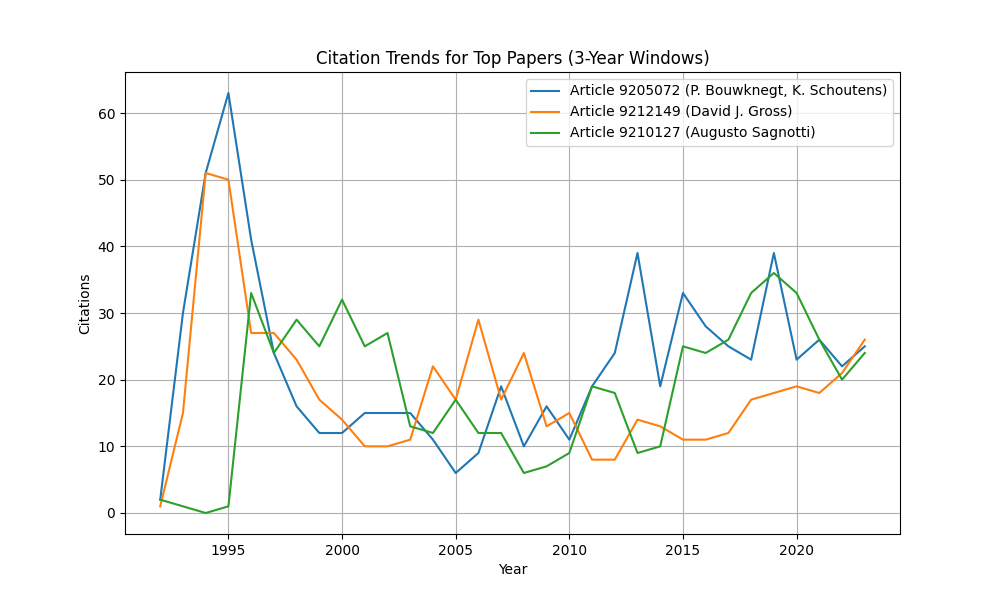

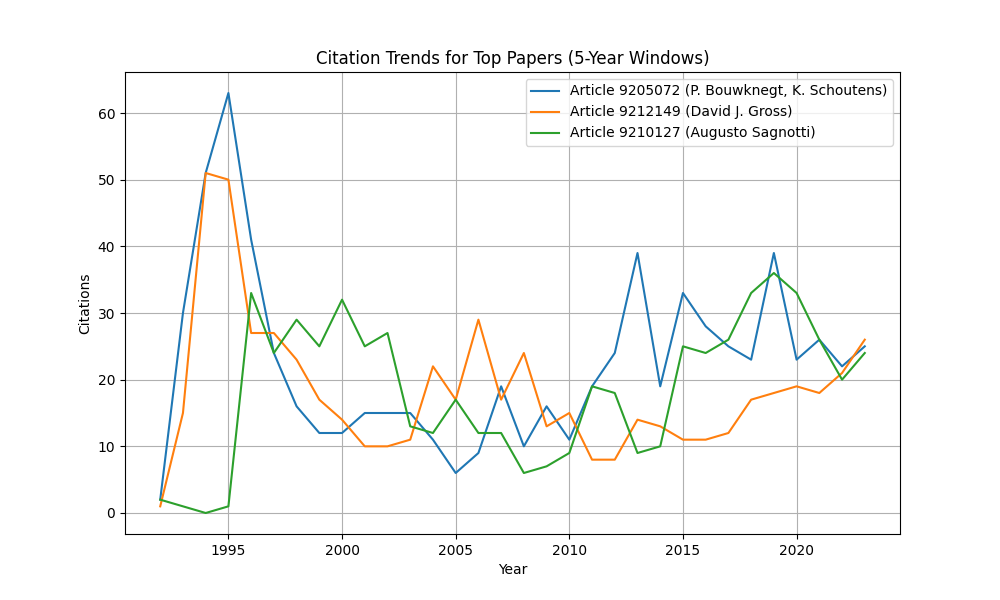

In [ ]:
# Step 0: Install dependencies
!pip install -q sentence-transformers openpyxl

# Step 1: Upload file
from google.colab import files
uploaded = files.upload()

import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 2: Load Excel file
# Replace 'top3.xlsx' with the exact filename you upload
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

print("Loaded data:")
print(df)

# Step 3: Extract abstracts (or you can concatenate title + abstract for richer text)
texts = df['Abstract'].fillna('').tolist()

# Step 4: Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, fast, good for semantic similarity

# Step 5: Get embeddings for each abstract
embeddings = model.encode(texts)

# Step 6: Compute cosine similarity matrix
sim_matrix = cosine_similarity(embeddings)

# Step 7: Format and display similarity matrix nicely
sim_df = pd.DataFrame(sim_matrix, index=df['Title'], columns=df['Title'])
print("\nSimilarity Matrix:")
print(sim_df)

# Optional: Save similarity matrix to CSV for download
sim_df.to_csv("similarity_matrix.csv")

print("\nSimilarity matrix saved as similarity_matrix.csv")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00


Saving top3.xlsx to top3.xlsx
Loaded data:
                                               Title  \
0               W-symmetry in Conformal Field Theory   
1  A Note on the Green - Schwarz Mechanism in Ope...   
2             Two Dimensional QCD as a String Theory   

                                            Abstract  
0  We review various aspects of W algebra symmetr...  
1  An interesting feature of some open superstrin...  
2  The partition function of two-dimensional QCD ...  


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Similarity Matrix:
Title                                               W-symmetry in Conformal Field Theory  \
Title                                                                                      
W-symmetry in Conformal Field Theory                                            1.000000   
A Note on the Green - Schwarz Mechanism in Open...                              0.503744   
 Two Dimensional QCD as a String Theory                                         0.417653   

Title                                               A Note on the Green - Schwarz Mechanism in Open - String Theories  \
Title                                                                                                                   
W-symmetry in Conformal Field Theory                                                         0.503744                   
A Note on the Green - Schwarz Mechanism in Open...                                           1.000000                   
 Two Dimensional QCD as a String Th

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from collections import defaultdict

def generate_time_windows(start_year, end_year, window_size):
    """Generate non-overlapping time windows of given size."""
    windows = []
    for year in range(start_year, end_year + 1, window_size):
        end_window = min(year + window_size - 1, end_year)
        windows.append((year, end_window))
    return windows

def compute_citations_in_window(df, start_year, end_year):
    """Compute total citations for each paper in the given year range."""
    year_columns = [str(year) for year in range(start_year, end_year + 1) if str(year) in df.columns]
    if not year_columns:
        return None

    # Sum citations across the years in the window
    df['Total Citations'] = df[year_columns].sum(axis=1)

    # Find the paper with the highest citations
    top_paper = df.loc[df['Total Citations'].idxmax()]
    return {
        'Article Id': top_paper['Article Id'],
        'Title': top_paper['Title'],
        'Author': top_paper['Author'],
        'Topic': top_paper['Topic'],
        'Total Citations': top_paper['Total Citations']
    }

def compute_citation_velocity(df, article_id, start_year, end_year):
    """Compute the citation velocity (rate of change) for a paper over a window."""
    paper = df[df['Article Id'] == article_id].iloc[0]
    year_columns = [str(year) for year in range(start_year, end_year + 1) if str(year) in df.columns]
    if len(year_columns) < 2:
        return 0  # Not enough data to compute velocity

    citations = [paper[year] for year in year_columns]
    velocities = [(citations[i+1] - citations[i]) for i in range(len(citations)-1)]
    avg_velocity = sum(velocities) / len(velocities) if velocities else 0
    return avg_velocity

def plot_citation_trends(df, top_papers, window_size):
    """Plot citation trends for top-cited papers over time."""
    plt.figure(figsize=(10, 6))
    years = list(range(1992, 2024))
    year_columns = [str(year) for year in years if str(year) in df.columns]

    for article_id in top_papers:
        paper = df[df['Article Id'] == article_id].iloc[0]
        citations = [paper[str(year)] for year in years if str(year) in df.columns]
        plt.plot([int(year) for year in year_columns], citations, label=f"Article {article_id} ({paper['Author']})")

    plt.xlabel('Year')
    plt.ylabel('Citations')
    plt.title(f'Citation Trends for Top Papers ({window_size}-Year Non-Overlapping Windows)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'citation_trends_{window_size}year_non_overlapping.png')
    plt.close()

def analyze_transitions(df, window_size=3):
    """Analyze transitions in top-cited papers for 3-year non-overlapping windows."""
    start_year = 1992
    end_year = 2023

    # Generate non-overlapping 3-year windows
    windows = generate_time_windows(start_year, end_year, window_size)
    window_results = []
    top_paper_ids = set()  # Track top papers for plotting

    # Compute top paper for each window
    for start, end in windows:
        result = compute_citations_in_window(df, start, end)
        if result:
            window_results.append({
                'Window': f"{start}-{end}",
                'Article Id': result['Article Id'],
                'Title': result['Title'],
                'Author': result['Author'],
                'Topic': result['Topic'],
                'Total Citations': result['Total Citations']
            })
            top_paper_ids.add(result['Article Id'])

    # Plot citation trends for top papers
    plot_citation_trends(df, top_paper_ids, window_size)

    # Analyze transitions
    print(f"\n### Analysis of Transitions in Top-Cited Papers ({window_size}-Year Non-Overlapping Windows)\n")
    transitions = []
    for i in range(len(window_results) - 1):
        current = window_results[i]
        next_window = window_results[i + 1]
        if current['Article Id'] != next_window['Article Id']:
            # Compute citation velocities
            old_velocity = compute_citation_velocity(df, current['Article Id'],
                                                    int(current['Window'].split('-')[0]),
                                                    int(current['Window'].split('-')[1]))
            new_velocity = compute_citation_velocity(df, next_window['Article Id'],
                                                    int(next_window['Window'].split('-')[0]),
                                                    int(next_window['Window'].split('-')[1]))
            # Check topic change
            topic_change = "Yes" if current['Topic'] != next_window['Topic'] else "No"

            transitions.append({
                'Transition Window': f"{current['Window']} to {next_window['Window']}",
                'Previous Top Paper': f"Article {current['Article Id']} ({current['Title']}) by {current['Author']}",
                'Previous Topic': current['Topic'],
                'Previous Citations': current['Total Citations'],
                'Previous Velocity': old_velocity,
                'New Top Paper': f"Article {next_window['Article Id']} ({next_window['Title']}) by {next_window['Author']}",
                'New Topic': next_window['Topic'],
                'New Citations': next_window['Total Citations'],
                'New Velocity': new_velocity,
                'Topic Change': topic_change
            })

    # Generate transition analysis table
    print("| Transition Window | Previous Top Paper | Previous Topic | Previous Citations | Previous Velocity | New Top Paper | New Topic | New Citations | New Velocity | Topic Change |")
    print("|-------------------|--------------------|----------------|--------------------|-------------------|---------------|-----------|---------------|--------------|--------------|")
    for t in transitions:
        print(f"| {t['Transition Window']} | {t['Previous Top Paper']} | {t['Previous Topic']} | {t['Previous Citations']} | {t['Previous Velocity']:.2f} | {t['New Top Paper']} | {t['New Topic']} | {t['New Citations']} | {t['New Velocity']:.2f} | {t['Topic Change']} |")

    # Summarize reasons
    print("\n### Summary of Reasons for Citation Shifts\n")
    for t in transitions:
        print(f"**Transition: {t['Transition Window']}**")
        print(f"- **Drop in Previous Paper (Article {t['Previous Top Paper'].split()[1]}):**")
        if t['Previous Velocity'] < 0:
            print(f"  - The citation velocity was negative ({t['Previous Velocity']:.2f}), indicating a decline in new citations.")
        else:
            print(f"  - The citation velocity slowed ({t['Previous Velocity']:.2f}), suggesting reduced interest.")
        if t['Topic Change'] == "Yes":
            print(f"  - Topic shift from '{t['Previous Topic']}' to '{t['New Topic']}' likely reflects a change in research focus.")
        print(f"- **Rise of New Paper (Article {t['New Top Paper'].split()[1]}):**")
        if t['New Velocity'] > 0:
            print(f"  - The citation velocity was positive ({t['New Velocity']:.2f}), indicating growing interest.")
        else:
            print(f"  - The citation velocity was stable or growing ({t['New Velocity']:.2f}).")
        if t['Topic Change'] == "Yes":
            print(f"  - The new topic '{t['New Topic']}' may have aligned with emerging research trends.")
        print()

    # Generate original table for reference
    print(f"\n### {window_size}-Year Non-Overlapping Windows (Top Paper)\n")
    print("| Window       | Article Id | Title                          | Author                | Topic         | Total Citations |")
    print("|--------------|------------|--------------------------------|-----------------------|---------------|-----------------|")
    for result in window_results:
        print(f"| {result['Window']} | {result['Article Id']} | {result['Title']} | {result['Author']} | {result['Topic']} | {result['Total Citations']} |")

    # Notify user about saved plots
    print(f"\nCitation trend plot has been saved as: citation_trends_{window_size}year_non_overlapping.png")

def main():
    print("Please upload your CSV file:")
    uploaded = files.upload()

    input_file = list(uploaded.keys())[0]
    df = pd.read_csv(input_file, encoding='utf-8', delimiter=',')
    df.columns = df.columns.str.strip()

    print("Loaded column names:", list(df.columns))

    required_columns = ['Article Id', 'Title', 'Author', 'Cited By', 'Topic']
    for col in required_columns:
        if col not in df.columns:
            raise KeyError(f"Required column '{col}' not found in CSV. Available columns: {list(df.columns)}")

    # Convert yearly citation columns to numeric, handle missing values
    for year in range(1992, 2024):
        if str(year) in df.columns:
            df[str(year)] = pd.to_numeric(df[str(year)], errors='coerce').fillna(0)

    analyze_transitions(df)

if __name__ == "__main__":
    main()
from google.colab import files
files.download('citation_trends_3year_non_overlapping.png')

Please upload your CSV file:


Saving snamod.csv to snamod.csv
Loaded column names: ['Article Id', 'Title', 'Author', 'Cited By', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'Status', 'Abstract', 'arXiv Id', 'Text', 'Topic']

### Analysis of Transitions in Top-Cited Papers (3-Year Non-Overlapping Windows)

| Transition Window | Previous Top Paper | Previous Topic | Previous Citations | Previous Velocity | New Top Paper | New Topic | New Citations | New Velocity | Topic Change |
|-------------------|--------------------|----------------|--------------------|-------------------|---------------|-----------|---------------|--------------|--------------|
| 1995-1997 to 1998-2000 | Article 9205072 (W-symmetry in Conformal Field Theory) by P. Bouwknegt, K. Schoutens | Topic 7: physic, modular, meromorphic, combinat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>